In [1]:
import pandas as pd
import csv
import numpy as np
import re
import string as string_library
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_validate
from sklearn import metrics
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV
import sys
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from nltk.stem.porter import PorterStemmer
import math
import warnings
import random
warnings.filterwarnings('ignore')
sys.setrecursionlimit(100000)

Starting with 515,999 random videos scraped from YouTube, I took the descriptions that were in English and then looked for the existence of potential coupon codes. Splitting the description into sentences, I kept track of any sentence that might have a coupon code. For example, Casey Neistat is a famous social media influencer with a YouTube channel called "CaseyNeistat". My dictionary generator would have checked the description of his videos for his full channel title, "CaseyNeistat", individual components of his channel title split on a lowercase to uppercase transitions or spaces, "Casey" and "Neistat", and then the initials of his channel title components, "CN". All of these could also have a number appended to the end. 170,473 sentences were found to have potential coupon codes, so I split clustered these sentences and manually inspected them. 

In this notebook, I read in the clustered sentences, and then label them as having a coupon code based on their cluster number. Adding in some random values from the set, I split the data into 3 subsets and train the model with different classifiers to get the best combination to classify the dataset. Then, using the best option, I check the performance overall and export the weights.

# Build the training set and then Classify

In [2]:
# read in the sentences that were already clustered
videos = []
match_ids = {}
with open("sentence_clusters_fastcluster_nonbinary_all.tsv", 'rt') as csvfile:
    reader = csv.reader(csvfile, delimiter='\t')
    for row in reader:
        if row[0] not in match_ids:
            match_ids[row[0]] = True
        videos.append([row[0], row[1], row[2], row[3], row[4]])
        
videos_en = pd.DataFrame(videos, columns=['id', 'description', 'channelTitle', 'sentence', 'clusterNum'])
del videos

In [3]:
# add in an isCoupon variable to the dataframe. isCoupon = 1 if the sentence is in our cluster of coupon codes
num_coupon_codes = 0
match_sentences = {}
for i, row in videos_en.iterrows():
    if row['clusterNum'] == str(68):
        num_coupon_codes += 1
        match_sentences[row.sentence] = True
        videos_en.at[i, 'isCoupon'] = 1
    else:
        videos_en.at[i, 'isCoupon'] = 0

In [4]:
print videos_en.shape

(77706, 6)


In [5]:
print num_coupon_codes

177


In [6]:
# There are few coupon codes compared to the size of the dataset
# Need to shrink the negative sample size in our training dataset
# get a random set of 1000 videos from the set
sample_set = videos_en.sample(n=1000)

In [7]:
sample_set.shape

(1000, 6)

In [8]:
# get the sentences that are in the coupon code cluster
positives = []
for i, row in videos_en.iterrows():
    if row['isCoupon'] == 1:
        positives.append([row.id, row.description, row.channelTitle, row.sentence, row.clusterNum, row.isCoupon])
        
positiveDF = pd.DataFrame(positives, columns=['id', 'description', 'channelTitle', 'sentence', 'clusterNum', 'isCoupon'])
del positives
print(positiveDF.shape)

(177, 6)


In [9]:
# join the set of random values and the set of positives
data = sample_set.append(positiveDF, ignore_index=True)
data.shape

(1177, 6)

In [10]:
#shuffle the training set
data = data.sample(frac=1).reset_index(drop=True)

In [11]:
y = data.isCoupon

In [12]:
#stemmer = PorterStemmer()

def tokenize(line):
    if (line is None):
        line = ''
    printable = set(string_library.printable)
    line = ''.join(filter(lambda x: x in printable, line)) 
    stopwords = nltk.corpus.stopwords.words('english')

    tokenizer = nltk.RegexpTokenizer(r'[a-zA-Z]*\'[a-zA-Z]*|\w+')
    
    tokens = []
    
    line = re.sub(r'(http[s]?://|www.)(?:[a-zA-Z]|[0-9]|[$-_@.&+]*|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))*', '', line).lower()
    tokens.extend(tokenizer.tokenize(line))
    
    tokens_ = [f.strip(string_library.punctuation) for f in tokens]
    for i in range(len(tokens_)):
        if tokens_[i][0:2] == "b'":
            tokens_[i] = tokens[i][2:]
    tokens_ = [f for f in tokens_ if f != '' and f not in stopwords and len(f) != 1]
    tokens_ = [f for f in tokens_ if not (f.isdigit() or f[0] == '-' and f[1:].isdigit())]
    #tokens_ = [stemmer.stem(f) for f in tokens_]

    return tokens_


In [13]:
# all of the possible parameters to check for
params = {'C': [0.01, 0.1, 0.5, 0.8, 0.9, 1, 1.2, 1.5, 2, 5, 10], 'kernel': ['linear', 'rbf', 'poly'], 'degree': [2, 3, 5, 10, 20, 50]}
clf = GridSearchCV(SVC(probability=True), params, cv=5)

Round 1
Best Params:  {'kernel': 'linear', 'C': 1.2, 'degree': 2}
Best Score:  1.0
{'score_time': array([0.00074196, 0.00069118, 0.0005579 , 0.00064087, 0.00053501]), 'test_score': array([1., 1., 1., 1., 1.]), 'train_score': array([1., 1., 1., 1., 1.]), 'fit_time': array([6.32287383, 6.39934301, 6.28397799, 6.34685302, 6.36714506])}
r2 score:  0.9234356781966576
F1 Score:  0.96875
Confusion matrix: 
[[164   2]
 [  0  31]]


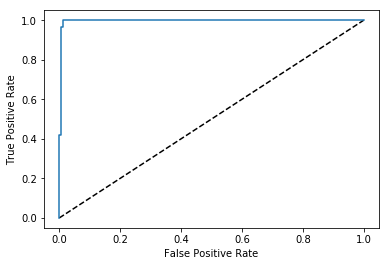

_______________________________________________________________
Round 2
Best Params:  {'kernel': 'linear', 'C': 0.5, 'degree': 2}
Best Score:  0.9949044585987261
{'score_time': array([0.00054312, 0.00054097, 0.00053883, 0.00054812, 0.00054097]), 'test_score': array([1.   , 0.975, 1.   , 1.   , 1.   ]), 'train_score': array([1.        , 1.        , 1.        , 0.99367089, 1.        ]), 'fit_time': array([6.20146585, 6.18313694, 6.107723  , 6.14869785, 6.14642501])}
r2 score:  1.0
F1 Score:  1.0
Confusion matrix: 
[[167   0]
 [  0  29]]


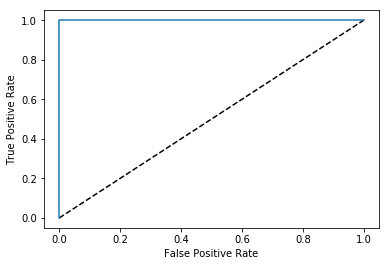

_______________________________________________________________
Round 3
Best Params:  {'kernel': 'linear', 'C': 1.5, 'degree': 2}
Best Score:  0.9974522292993631
{'score_time': array([0.00060105, 0.00063515, 0.00053811, 0.00058103, 0.000561  ]), 'test_score': array([1.        , 0.97435897, 1.        , 0.97435897, 1.        ]), 'train_score': array([1.        , 0.99363057, 1.        , 0.99363057, 1.        ]), 'fit_time': array([6.44439578, 6.67053795, 6.42922282, 6.49685597, 6.46656799])}
r2 score:  1.0
F1 Score:  1.0
Confusion matrix: 
[[165   0]
 [  0  31]]


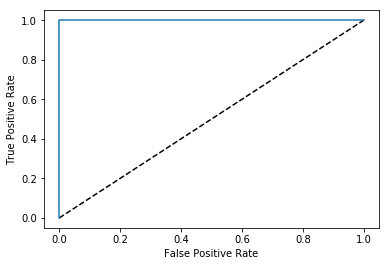

_______________________________________________________________


In [14]:
# run kfold 3 times
kf = KFold(n_splits=3, shuffle=True)
kf.get_n_splits(data)
round_num = 0
for train_index, test_index in kf.split(data):
    round_num += 1
    print 'Round', round_num
    #get the training, validating, and testing sets for the sentences
    X_train, X_temp = data.loc[train_index], data.loc[test_index]
    split_X = np.split(X_temp, [X_temp.shape[0]/2])
    X_validate = split_X[0]
    X_test = split_X[1]
    #get the training, validating, and testing sets for the isCoupon types
    y_train, y_temp = y.loc[train_index], y.loc[test_index]
    split_y = np.split(y_temp, [y_temp.shape[0]/2])
    y_validate = split_y[0]
    y_test = split_y[1]
    
    #Get the word vector from the training set
    countVec = CountVectorizer(tokenizer=tokenize, min_df=3).fit(X_train['sentence'])
    #create the word frequency from the word vector for the training, validating, and testing sets
    lineVec = countVec.transform(X_train['sentence'])
    validateVec = countVec.transform(X_validate['sentence'])
    testVec = countVec.transform(X_test['sentence'])
    
    #fit the classifier
    clf.fit(lineVec, X_train['isCoupon'])
    print "Best Params: ", clf.best_params_
    print "Best Score: ", clf.best_score_
    
    #cross validate
    cv_results = cross_validate(clf, validateVec, y_validate, cv=5, return_train_score=True)
    print cv_results
    
    #test on the test set
    predictions = clf.predict(testVec)
    print 'r2 score: ', metrics.r2_score(y_test, predictions)
    print 'F1 Score: ', metrics.f1_score(y_test, predictions)
    print 'Confusion matrix: '
    print metrics.confusion_matrix(y_test, predictions)
    predicted_probabilites = clf.predict_proba(testVec)[:,1]
    fpr, tpr, thresholds = metrics.roc_curve(y_test, predicted_probabilites) 
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='Logistic Regression')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()
    print '_______________________________________________________________'

In [15]:
# all of the possible parameters to check for
params = {'n_estimators': [1, 3, 5, 7, 10, 15], 'max_depth': [None, 1, 5, 10, 15, 30]}
clf = GridSearchCV(RandomForestClassifier(), params, cv=5)

Round 1
Best Params:  {'n_estimators': 15, 'max_depth': 30}
Best Score:  0.9974489795918368
{'score_time': array([0.00222802, 0.00159001, 0.00215793, 0.00073695, 0.00159001]), 'test_score': array([1.        , 1.        , 1.        , 0.97435897, 0.97368421]), 'train_score': array([1.        , 1.        , 1.        , 0.99363057, 1.        ]), 'fit_time': array([4.51333094, 4.56100893, 4.34861803, 4.159091  , 4.24103189])}
r2 score:  1.0
F1 Score:  1.0
Confusion matrix: 
[[173   0]
 [  0  24]]


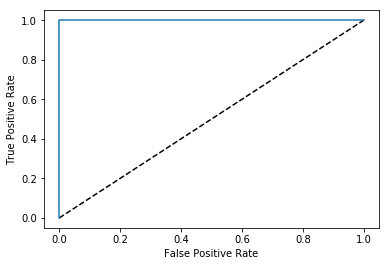

_______________________________________________________________
Round 2
Best Params:  {'n_estimators': 3, 'max_depth': 30}
Best Score:  0.9961783439490446
{'score_time': array([0.00166297, 0.0021081 , 0.00183702, 0.001333  , 0.00142002]), 'test_score': array([1., 1., 1., 1., 1.]), 'train_score': array([1., 1., 1., 1., 1.]), 'fit_time': array([4.29612803, 4.32973409, 4.41119695, 4.67784595, 4.66361094])}
r2 score:  0.8425702811244979
F1 Score:  0.9354838709677419
Confusion matrix: 
[[163   3]
 [  1  29]]


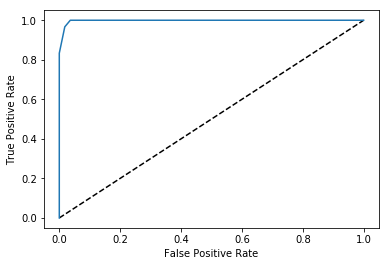

_______________________________________________________________
Round 3
Best Params:  {'n_estimators': 10, 'max_depth': None}
Best Score:  0.9974522292993631
{'score_time': array([0.00132585, 0.0011909 , 0.00081897, 0.00165701, 0.00107002]), 'test_score': array([1.        , 0.94871795, 0.97435897, 0.97435897, 1.        ]), 'train_score': array([0.99358974, 1.        , 0.96815287, 0.99363057, 1.        ]), 'fit_time': array([4.45734096, 4.46622109, 4.44843507, 4.44232297, 4.45227695])}
r2 score:  0.9666836647968724
F1 Score:  0.9866666666666666
Confusion matrix: 
[[158   1]
 [  0  37]]


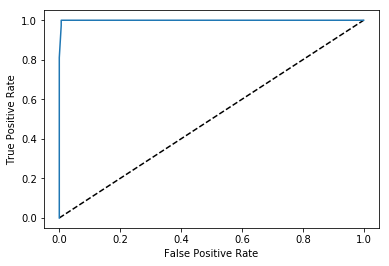

_______________________________________________________________


In [16]:
# run kfold 3 times
kf = KFold(n_splits=3, shuffle=True)
kf.get_n_splits(data)
round_num = 0
for train_index, test_index in kf.split(data):
    round_num += 1
    print 'Round', round_num
    #get the training, validating, and testing sets for the sentences
    X_train, X_temp = data.loc[train_index], data.loc[test_index]
    split_X = np.split(X_temp, [X_temp.shape[0]/2])
    X_validate = split_X[0]
    X_test = split_X[1]
    #get the training, validating, and testing sets for the isCoupon types
    y_train, y_temp = y.loc[train_index], y.loc[test_index]
    split_y = np.split(y_temp, [y_temp.shape[0]/2])
    y_validate = split_y[0]
    y_test = split_y[1]
    
    #Get the word vector from the training set
    countVec = CountVectorizer(tokenizer=tokenize, min_df=3).fit(X_train['sentence'])
    #create the word frequency from the word vector for the training, validating, and testing sets
    lineVec = countVec.transform(X_train['sentence'])
    validateVec = countVec.transform(X_validate['sentence'])
    testVec = countVec.transform(X_test['sentence'])
    
    #fit the classifier
    clf.fit(lineVec, X_train['isCoupon'])
    print "Best Params: ", clf.best_params_
    print "Best Score: ", clf.best_score_
    
    #cross validate
    cv_results = cross_validate(clf, validateVec, y_validate, cv=5, return_train_score=True)
    print cv_results
    
    #test on the test set
    predictions = clf.predict(testVec)
    print 'r2 score: ', metrics.r2_score(y_test, predictions)
    print 'F1 Score: ', metrics.f1_score(y_test, predictions)
    print 'Confusion matrix: '
    print metrics.confusion_matrix(y_test, predictions)
    predicted_probabilites = clf.predict_proba(testVec)[:,1]
    fpr, tpr, thresholds = metrics.roc_curve(y_test, predicted_probabilites) 
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='Logistic Regression')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()
    print '_______________________________________________________________'

In [17]:
# all of the possible parameters to check for
params = {'max_depth':[None, 1, 5, 10, 15, 30]}
clf = GridSearchCV(DecisionTreeClassifier(), params, cv=5)

Round 1
Best Params:  {'max_depth': None}
Best Score:  0.9987244897959183
{'score_time': array([0.00046492, 0.00050712, 0.00047278, 0.00053787, 0.00051117]), 'test_score': array([1., 1., 1., 1., 1.]), 'train_score': array([1., 1., 1., 1., 1.]), 'fit_time': array([0.1243391 , 0.12681198, 0.12686801, 0.12445498, 0.12565494])}
r2 score:  0.9617178390983288
F1 Score:  0.9841269841269841
Confusion matrix: 
[[165   1]
 [  0  31]]


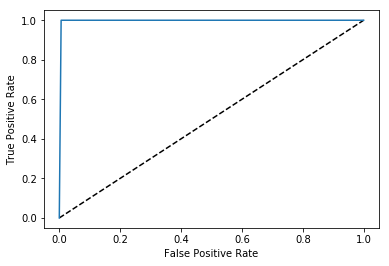

_______________________________________________________________
Round 2
Best Params:  {'max_depth': None}
Best Score:  0.9974522292993631
{'score_time': array([0.00048089, 0.00047112, 0.00049806, 0.00046992, 0.00054598]), 'test_score': array([1., 1., 1., 1., 1.]), 'train_score': array([1., 1., 1., 1., 1.]), 'fit_time': array([0.12962413, 0.12810397, 0.13962197, 0.13554406, 0.12630296])}
r2 score:  1.0
F1 Score:  1.0
Confusion matrix: 
[[168   0]
 [  0  28]]


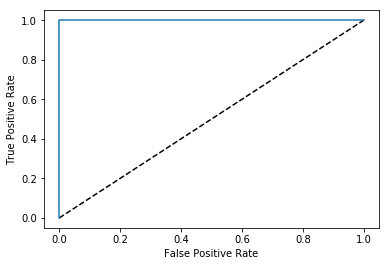

_______________________________________________________________
Round 3
Best Params:  {'max_depth': None}
Best Score:  0.9987261146496815
{'score_time': array([0.0005219 , 0.00060105, 0.00048995, 0.00055885, 0.00059986]), 'test_score': array([0.975     , 1.        , 1.        , 1.        , 0.94871795]), 'train_score': array([1., 1., 1., 1., 1.]), 'fit_time': array([0.1275661 , 0.12734389, 0.12653518, 0.12633801, 0.12608695])}
r2 score:  0.8906860011154489
F1 Score:  0.9538461538461539
Confusion matrix: 
[[162   1]
 [  2  31]]


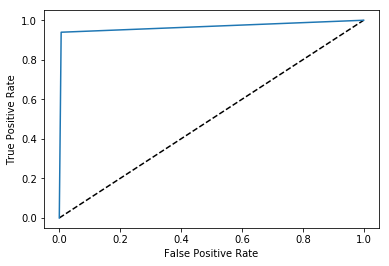

_______________________________________________________________


In [18]:
# run kfold 3 times
kf = KFold(n_splits=3, shuffle=True)
kf.get_n_splits(data)
round_num = 0
for train_index, test_index in kf.split(data):
    round_num += 1
    print 'Round', round_num
    #get the training, validating, and testing sets for the sentences
    X_train, X_temp = data.loc[train_index], data.loc[test_index]
    split_X = np.split(X_temp, [X_temp.shape[0]/2])
    X_validate = split_X[0]
    X_test = split_X[1]
    #get the training, validating, and testing sets for the isCoupon types
    y_train, y_temp = y.loc[train_index], y.loc[test_index]
    split_y = np.split(y_temp, [y_temp.shape[0]/2])
    y_validate = split_y[0]
    y_test = split_y[1]
    
    #Get the word vector from the training set
    countVec = CountVectorizer(tokenizer=tokenize, min_df=3).fit(X_train['sentence'])
    #create the word frequency from the word vector for the training, validating, and testing sets
    lineVec = countVec.transform(X_train['sentence'])
    validateVec = countVec.transform(X_validate['sentence'])
    testVec = countVec.transform(X_test['sentence'])
    
    #fit the classifier
    clf.fit(lineVec, X_train['isCoupon'])
    print "Best Params: ", clf.best_params_
    print "Best Score: ", clf.best_score_
    
    #cross validate
    cv_results = cross_validate(clf, validateVec, y_validate, cv=5, return_train_score=True)
    print cv_results
    
    #test on the test set
    predictions = clf.predict(testVec)
    print 'r2 score: ', metrics.r2_score(y_test, predictions)
    print 'F1 Score: ', metrics.f1_score(y_test, predictions)
    print 'Confusion matrix: '
    print metrics.confusion_matrix(y_test, predictions)
    predicted_probabilites = clf.predict_proba(testVec)[:,1]
    fpr, tpr, thresholds = metrics.roc_curve(y_test, predicted_probabilites) 
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='Logistic Regression')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()
    print '_______________________________________________________________'

# Check How the weights will work in the Browser Extension

In [60]:
# build the classifier with the best values found above
classifier = SVC(kernel='linear', C=1, degree=2)
X_temp = np.split(data, [data.shape[0]/2])
X_train = X_temp[0]
split_X = np.split(X_temp[1], [X_temp[1].shape[0]/2])
X_validate = split_X[0]
X_test = split_X[1]
print X_train.shape
print X_validate.shape
print X_test.shape

(588, 6)
(294, 6)
(295, 6)


In [61]:
#Get the word vectors
countVec = CountVectorizer(tokenizer=tokenize, min_df=3).fit(X_train['sentence'])

In [62]:
#transform sentences into vectors
lineVec = countVec.transform(X_train['sentence'])
validateVec = countVec.transform(X_validate['sentence'])
testVec = countVec.transform(X_test['sentence'])

In [63]:
print lineVec.shape
print validateVec.shape
print testVec.shape

(588, 202)
(294, 202)
(295, 202)


In [64]:
#fit the classifier
classifier.fit(lineVec, X_train['isCoupon'])

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=2, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [65]:
predictions = classifier.predict(testVec)
print 'r2 score: ', metrics.r2_score(X_test['isCoupon'], predictions)
print 'F1 Score: ', metrics.f1_score(X_test['isCoupon'], predictions)

r2 score:  1.0
F1 Score:  1.0


In [66]:
cross_validate(clf, validateVec, X_validate['isCoupon'], cv=5, return_train_score=True)

{'fit_time': array([0.13646793, 0.13410878, 0.13256097, 0.11841512, 0.12298179]),
 'score_time': array([0.00058794, 0.00047016, 0.00046706, 0.00046587, 0.00046706]),
 'test_score': array([0.96666667, 1.        , 0.98305085, 1.        , 1.        ]),
 'train_score': array([1., 1., 1., 1., 1.])}

In [67]:
predictions = classifier.predict(testVec)

In [68]:
print 'r2 score: ', metrics.r2_score(X_test['isCoupon'], predictions)
print 'F1 Score: ', metrics.f1_score(X_test['isCoupon'], predictions)

r2 score:  1.0
F1 Score:  1.0


In [69]:
features = countVec.get_feature_names()
weights = classifier.coef_.toarray()[0]
for i in range(len(weights)):
    if weights[i] > 0:
        print "%1.5f" % weights[i], "\t", features[i]

0.00794 	also
0.27748 	available
0.00009 	check
1.99962 	checkout
0.03693 	cinchgaming
1.99979 	code
1.00000 	codes
0.01588 	competition
0.00028 	coupon
0.09483 	discount
0.32617 	free
0.02641 	gfuel
0.00038 	head
0.00028 	hertz
0.04200 	products
0.00028 	rb
0.00029 	red
0.02641 	swifterrs


In [70]:
features = countVec.get_feature_names()

def get_vector(sentence):
    vector = [0] * len(features)
    tokens = tokenize(sentence)
    for token in tokens:
        if token in features:
            vector[features.index(token)] += 1
    return vector

In [71]:
false_positives = 0
false_negatives = 0
for i, row in videos_en.iterrows():
    tot = 0
    vector = get_vector(row['sentence'])
    for j in range(len(weights)):
        tot += weights[j] * vector[j]
    if tot > 0.5:
        if row['isCoupon'] == 0:
            #print "False +: ", row['sentence']
            false_positives += 1
    else:
        if row['isCoupon'] == 1:
            false_negatives += 1
            #print "False -: ", row['sentence']

In [72]:
total_vids = videos_en.shape[0]
print "Total Inputs: ", total_vids
print "False Positives: ", false_positives # some of these are coupon codes
print "False Positive Percentage: %1.2f" % (false_positives/(total_vids*1.0) * 100), "%"
print "False Negatives: ", false_negatives # could be a result of imperfections in the cluster
print "False Negative Percentage: %1.2f" % (false_negatives/(total_vids*1.0) * 100), "%"

Total Inputs:  77706
False Positives:  197
False Positive Percentage: 0.25 %
False Negatives:  0
False Negative Percentage: 0.00 %


# Export features and Weights

In [ ]:
features = countVec.get_feature_names()
non_zero_features = []
print len(features), len(weights)
num_zeroes = 0
weights_string = "const CouponWeights = ["
for i in range(len(weights)):
    item = weights[i]
    if item == 0:
        num_zeroes += 1
    else:
        non_zero_features.append(features[i])
        weights_string += '%1.15f' % item + ", "
weights_string = weights_string[0:-2] + "];"

features_string = "const CouponFeatures = ["
for item in non_zero_features:
    temp = item
    features_string += '"' + temp + '",'
features_string = features_string[0:-1] + "];"

print weights_string
print features_string
print len(non_zero_features), len(weights)-num_zeroes

In [ ]:
print "[",
for word in nltk.corpus.stopwords.words('english'):
    print "\"" + word+ "\"", ",",

In [ ]:
# kf = KFold(n_splits=3, shuffle=True)
# kf.get_n_splits(videos_en_new)
# round_num = 0
# for train_index, test_index in kf.split(videos_en_new):
#     round_num += 1
#     print 'Round', round_num
#     X_train, X_test = videos_en_new.loc[train_index], videos_en_new.loc[test_index]
#     y = videos_en_new.isCoupon
#     y_train, y_test = y.loc[train_index], y.loc[test_index]
#     lineVec = countVec.transform(X_train['sentence'])
#     testVec = countVec.transform(X_test['sentence'])
#     clf.fit(lineVec, X_train['isCoupon'])
#     predictions = clf.predict(testVec)
#     print "Best Params: ", clf.best_params_
#     print "Best Score: ", clf.best_score_
#     #print 'AUC Cross-validated scores:', cross_val_score(clf, lineVec, y_train, cv=5, scoring='roc_auc')
#     print 'r2 score: ', metrics.r2_score(y_test, predictions)
#     print 'F1 Score: ', metrics.f1_score(y_test, predictions)
#     print 'Confusion matrix: '
#     print metrics.confusion_matrix(y_test, predictions)
#     predicted_probabilites = clf.predict_proba(testVec)[:,1]
#     fpr, tpr, thresholds = metrics.roc_curve(y_test, predicted_probabilites) 
#     plt.plot([0, 1], [0, 1], 'k--')
#     plt.plot(fpr, tpr, label='Logistic Regression')
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.show()
#     print '_______________________________________________________________'